## Temat 1. Własna sieć neuronowa
Celem projektu jest samodzielne zaimplementowanie prostej sieci neuronowej i przetestowanie jej na wybranym przez siebie przykładzie.

Podstawowym założeniem projektu jest własnoręczne zaimplementowanie automatycznego różniczkowania w celu wyznaczania pochodnych warstw potrzebnych do wstecznej   propagacji błędów. Dopuszczalne jest wykorzystanie różniczkowanie w przód (ang. Forward Accumulation), różniczkowanie w tył (ang. Reverse Accumulation) oraz różniczkowanie oparte o generację kodu (ang. source-to-source differentiation).

Do implementacji optymalizatorów dokonujących właściwego uczenia sieci można wykorzystać kod zamieszczony w książce "Algorithms for Optimization" [1].

klasyfikacja cyfr (Digits MNIST dataset)  
Bibliografia:  
[1] Mykel J. Kochenderfer, Tim A. Wheeler, 2019, Algorithms for Optimization, MIT Press.  
[2] Martin T. Hagan et. al, Neural Network Design, pp. 915-918, url: https://hagan.okstate.edu/NNDesign.pdf  
[3] 3blue1brown: czym są sieci neuronowe? https://www.youtube.com/watch?v=aircAruvnKk  
  


In [1]:
using Pkg
Pkg.activate("./project")

  Activating project at `e:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project`


In [2]:
Pkg.add("MLDatasets")
Pkg.add("IJulia")
Pkg.add("StableRNGs")
Pkg.add("DataFrames")
Pkg.add("PyPlot")
ENV["PYTHON"]=""

    Updating registry at `C:\Users\parzy\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Project.toml`
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Manifest.toml`
   Resolving package versions...
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Project.toml`
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Manifest.toml`
   Resolving package versions...
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Project.toml`
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Manifest.toml`
   Resolving package versions...
  No Changes to `E:\Documents\1. Studia\MAGISTERSKIE\Algorytmy w inż danych\Custom-Julia-NN\project\Project.

""

# Load Dataset

In [116]:
using RDatasets
iris = dataset("datasets", "iris")
X = Matrix(iris[:, 1:4])
y = iris.Species

150-element CategoricalArrays.CategoricalArray{String,1,UInt8}:
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 ⋮
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"

In [114]:
using Random
using Statistics
function custom_split(X, y::AbstractVector; dims=1, ratio_train=0.8, kwargs...)
    n = length(y)
    size(X, dims) == n || throw(DimensionMismatch("..."))

    n_train = round(Int, ratio_train*n)
    i_rand = randperm(n)
    i_train = i_rand[1:n_train]
    i_test = i_rand[n_train+1:end]

    return selectdim(X, dims, i_train), y[i_train], selectdim(X, dims, i_test), y[i_test]
end

function normalize(X_train, X_test; dims=1, kwargs...)
    col_mean = mean(X_train; dims)
    col_std = std(X_train; dims)

    return (X_train .- col_mean) ./ col_std, (X_test .- col_mean) ./ col_std
end

function onehot(y, classes)
    y_onehot = falses(length(classes), length(y))
    for (i, class) in enumerate(classes)
        y_onehot[i, y.==class] .= 1
    end
    return y_onehot
end

function prepare_data(X, y; do_normal=true, do_onehot=true, kwargs...)
    X_train, y_train, X_test, y_test = custom_split(X, y; kwargs...)

    if do_normal
        X_train, X_test = normalize(X_train, X_test; kwargs...)
    end

    classes = unique(y)

    if do_onehot
        y_train = onehot(y_train, classes)
        y_test = onehot(y_test, classes)
    end

    return X_train, y_train, X_test, y_test, classes
end

prepare_data (generic function with 1 method)

In [117]:

X_train, y_train, X_test, y_test, classes = prepare_data(X', y; dims=2)

([-0.9567091360207884 2.381341432026811 … 0.5931000562870261 -1.0759252277367737; 0.6144932030632493 1.803834886411472 … 0.1387565297239609 1.0902298764025389; -1.2820588232454333 1.4311913692889917 … 0.9116328217823995 -1.5129737332483628; -1.0291490117089084 0.971356626602144 … 0.7046225414940037 -1.2958830968170487], Bool[1 0 … 0 1; 0 0 … 0 0; 0 1 … 1 0], [-0.5990608608728306 -1.4335735028847305 … 0.11623568942308302 0.11623568942308302; -0.0991118069456838 0.37662486639360565 … -0.812716816954617 -2.0020585003028395; 0.3343455467750751 -1.5129737332483628 … 0.6807179117794695 0.6229891842787373; 0.30452141383179315 -1.429250139371119 … 0.43788845638586343 0.30452141383179315], Bool[0 1 … 0 0; 1 0 … 1 0; 0 0 … 0 1], ["setosa", "versicolor", "virginica"])

###  Automatic differentation- foward accumulation

In [49]:
# Dual number
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end


### Overloading functions and operators

In [50]:
import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

import Base: abs, sin, cos, tan, exp, sqrt, isless, log, max, min
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;
max(x::Dual, y::Dual) =Dual(max(x.v , y.v),if x.v>y.v 1*x.dv  else 1*y.dv end); # what about dv
min(x::Dual, y::Dual) =Dual(min(x.v , y.v),if x.v<y.v 1*x.dv  else 1*y.dv end); # what about dv
log(x::Dual) = Dual(log(x.v), (1/abs(x.v))*x.dv) 



log (generic function with 24 methods)

In [51]:
import Base: convert, promote_rule

convert(::Type{Dual{T}}, x::Dual) where {T} = Dual(convert(T, x.v), convert(T, x.dv))
@show Dual{Float64}[Dual(1, 2), Dual(3, 0)];
convert(::Type{Dual{T}}, x::Number) where {T} = Dual(convert(T, x), zero(T))
@show Dual{Float64}[1, 2, 3];
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T, R)}
@show Dual(1, 2) * 3;

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

Dual{Float64}[Dual(1, 2), Dual(3, 0)] = Dual{Float64}[(1.0) + [2.0ϵ], (3.0) + [0.0ϵ]]
Dual{Float64}[1, 2, 3] = Dual{Float64}[(1.0) + [0.0ϵ], (2.0) + [0.0ϵ], (3.0) + [0.0ϵ]]
Dual(1, 2) * 3 = (3) + [6ϵ]


In [52]:
D = derivative(f, x) = partials(f(Dual(x, one(x))))

derivative (generic function with 1 method)

In [108]:
J = function jacobian(f, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]

    for i=1:length(args)
        x = Dual{T}[]
        for j=1:length(args)
            seed = (i == j)
            push!(x, seed ?
                Dual(args[j], one(args[j])) :
                Dual(args[j],zero(args[j])) )
        end
        column = partials.([f(x)...])
        push!(jacobian_columns, column[:,:])
    end
    hcat(jacobian_columns...)
end

jacobian (generic function with 1 method)

In [107]:
H = function hessian(f, args::Vector)
    ∇f(x::Vector) = J(f, x)
    J(∇f, args)
end

hessian (generic function with 1 method)

In [55]:
import LinearAlgebra: diagm
diagonal(m) = diagm(0 => vec(m))

diagonal (generic function with 1 method)

### Activation functions

In [106]:
softmax(x)  =  exp.(x) ./ sum(exp.(x));
dsoftmax(x) = (softmax(x) |> diagonal) .- softmax(x) * (softmax(x) |> transpose);

ReLU(x) = max(zero(x), x)
identityFunction(x) = x

σ(x) = one(x) / (one(x) + exp(-x))
tanh(x) = 2.0 / (one(x) + exp(-2.0x)) - one(x)

tanh (generic function with 1 method)

### Cost functions

In [104]:
mean_squared_loss(y::Vector, ŷ::Vector) = sum(0.5(y - ŷ).^2)

function binary_cross_entropy(y::Vector, ŷ::Vector) 
    epsilon = eps(1.0)
    ## Avoding 0 , 1 in log argument
    ŷ = [max(i, epsilon) for i in ŷ]
    ŷ = [min(i, 1-epsilon) for i in ŷ]
    return -sum(y .* log.(ŷ) + (1 .- y) .* log.(1 .- ŷ)) / length(y)
end

binary_cross_entropy (generic function with 1 method)

### Network initialization

In [59]:
mutable struct Layer
    Wh::Matrix
    dWh::Matrix
    m::Int
    n::Int
    activation::Function
    Layer(n::Int64,m::Int64,activation::Function=identityFunction) = new(randn(n,m),randn(n,m),m,n,activation) #constructor
end

mutable struct Network
    layers::Vector{Layer} 
    Network(layers::Vararg{Layer}) = new(vcat(layers...)) 
end

### Pretty printing for Neural Netowwrk structures

In [60]:
import Base: show, summary
show(io::IO, x::Network) = begin
    print("Neural Netowrk | ") 
    print("Number of layers : $(length(x.layers))") 
    println("\nLayers: ")
    for (i,layer) in enumerate(x.layers)
        print("\t$i. ")
        print(layer)
    end
end

show(io::IO, x::Layer) = begin
    print("Layer : ") 
    print("shape: $(x.m)x$(x.n)") 
    println(" - activation function: $(x.activation)")
end

show (generic function with 457 methods)

In [100]:
# Custom Jacobiaon function for Nest structure
JacobianStruct = function Jacobian(m,f,layer_index, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    for i in 1:length(args)
        x = Dual{T}[]
        for j = 1:length(args)
            seed = (i == j)
            push!(x, seed ?
                     Dual(args[j], one(args[j])) :
                     Dual(args[j], zero(args[j])))
        end
        column = partials.([f(x)...])
        push!(jacobian_columns, column[:, :])
    end
    column = partials.([f(x)...])
end

Jacobian (generic function with 1 method)

In [96]:
(m::Layer)(x) = m.activation.(reshape(m.Wh, m.n, m.m) * x)
(m::Network)(x) = reduce((left, right) -> right ∘ left, m.layers)(x)

In [103]:


grad(m::Network, x, y, lr) =
    let
        dW_updates = []
        ### Backpropagation
        for (i, layer) in enumerate(m.layers)
            dWh = JacobianStruct(m, w -> foward_with_seed(m, x, y, w, i), i, layer.dWh[:])
        end

        ### Update weights
        for (i, layer) in enumerate(m.layers)
            m.dWh -= lr * dW_updates[i]
        end

    end

foward_with_seed(m::Network, x, y, w, i) =
    let
        m.layers[i].Wh = w[:, :]  #Inject seed  
        for (i, layer) in enumerate(m.layers)
            x = layer(x)
        end
        L = mean_squared_loss(y, x)
        return L
    end


foward(m::Network, x, y) =
    let
        for (i, layer) in enumerate(m.layers)
            x = layer(x)
        end
        L = mean_squared_loss(y, x)
        return L
    end



foward (generic function with 2 methods)

In [102]:
x = [10, 4, 4, 8, 4, 1, 9, 0, 0, 1, 10, 3, 5, 3, 5, 4, 6, 5, 10, 6, 2, 10, 8, 1]
y = [0,0,0,0,0,0,1,0,0]
twoLayerNeuralNet = Network(Layer(36,24,σ),Layer(9,36,σ)) #instantiate a two-layer network
foward(twoLayerNeuralNet,x,y)  

2.361608504540561

In [101]:
grad(twoLayerNeuralNet, x, y, 0.1)

DimensionMismatch: DimensionMismatch("new dimensions (36, 24) must be consistent with array size 24")

In [120]:
mean_squared_loss(y::BitVector, ŷ::Vector) = sum(0.5(y - ŷ).^2)
fullyconnected(w::Vector, n::Number, m::Number, v::Vector, activation::Function) = activation.(reshape(w, n, m) * v)
σ(x) = one(x) / (one(x) + exp(-x))


function foward(x, wh, wo, y)
    x̂ = fullyconnected(wh, 4, 4, x, σ)
    ŷ = fullyconnected(wo, 3, 4, x̂, u -> u)
end

function net(x, wh, wo, y)
    x̂ = fullyconnected(wh, 4, 4, x, ReLU)
    ŷ = fullyconnected(wo, 3, 4, x̂, u -> u)
    E = mean_squared_loss(y, ŷ)
end

function train(epochs::Int, lr::Float64, X_data, y_data)

    X_data = X_train
    y_data = y_data

    Wh = randn(4, 4)
    Wo = randn(3, 4)
    dWh = similar(Wh)
    dWo = similar(Wo)

    Loss_history = Float64[]

    for epoch = 1:epochs
        epoch_L = []
        for i in 1:size(X_train)[2]
            x = X_train[:, i]
            y = y_data[:, i]
            L = net(x, Wh[:], Wo[:], y)
            dnet_Wh(x, wh, wo, y) = J(w -> net(x, w, wo, y), wh)
            dWh[:] = dnet_Wh(x, Wh[:], Wo[:], y)
            dnet_Wo(x, wh, wo, y) = J(w -> net(x, wh, w, y), wo)
            dWo[:] = dnet_Wo(x, Wh[:], Wo[:], y)
            #push!(Loss_history, L)
            push!(epoch_L, L)
            Wh -= lr * Wh
            Wo -= lr * dWo
        end
      push!(Loss_history, std(epoch_L))
    end
    return Loss_history
end

train (generic function with 1 method)

In [121]:
#X_train, y_train, X_test, y_test, classes
history = train(10, 0.01, X_train, y_train)

10-element Vector{Float64}:
 1.8659204799131222
 0.1361480816194746
 0.04191824702030254
 0.013598271936213041
 0.004192622315211514
 0.0012668497862709435
 0.0003803359050789769
 0.00011396120850425649
 3.412637921356285e-5
 1.0217542483681654e-5

## Plots

Plots.plot(history) = Plot{Plots.GRBackend() n=1}


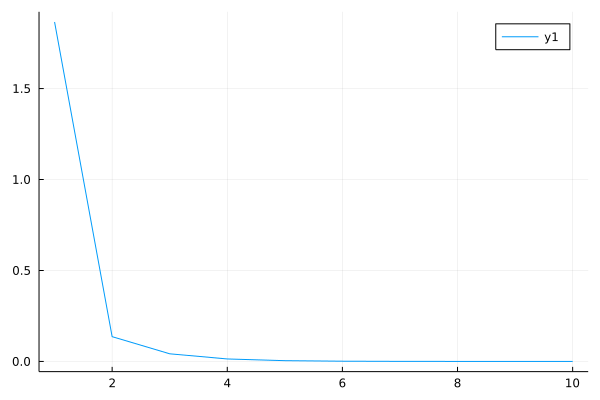

In [123]:
using Plots
@show Plots.plot(history)